In [63]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [66]:
dataset= pd.read_csv("airline-passengers.csv")

In [67]:
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format= True)
indexedDataset = dataset.set_index(['Month'])

In [72]:
from datetime import datetime
indexedDataset.tail()

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


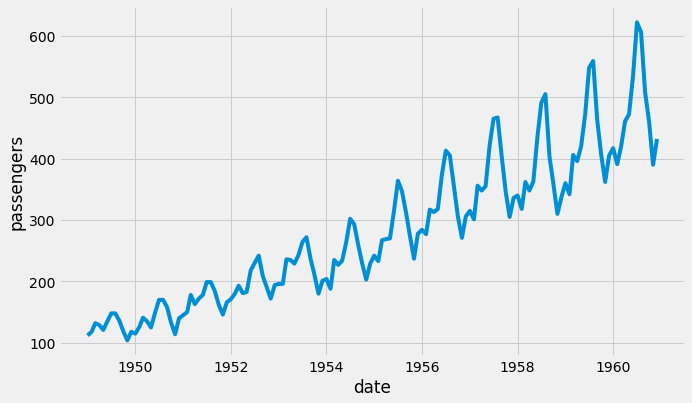

In [70]:
plt.xlabel('date')
plt.ylabel('passengers')
plt.plot(indexedDataset)

In [78]:
# Determining rolling statistics

rolmean = indexedDataset.rolling(window=12).mean()

rolstd = indexedDataset.rolling(window=12).std()
print(rolmean)
print(rolstd)


            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]
            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


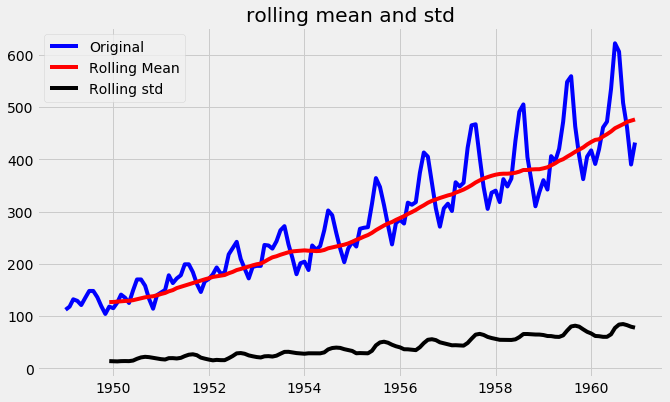

In [81]:
# plot rolling statistics 
orig = plt.plot(indexedDataset, color ='blue', label = 'Original')
mean = plt.plot(rolmean, color ='red', label = 'Rolling Mean')
std = plt.plot(rolstd, color ='black', label = 'Rolling std')
plt.legend(loc='best')
plt.title('rolling mean and std')
plt.show(block = False)

In [88]:
#perform Dicky-Fuller test
from statsmodels.tsa.stattools import adfuller
print("results of dicky-fuller test :")

dftest = adfuller(indexedDataset['Passengers'], autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '#Lags-Used', ' No of observations used'])
for key,value in dftest[4].items():
    dfoutput['Criical Value (%s)'%key] = value
    
print(dfoutput)    
    #p values should always be less
    #critical value greater then test statistics


results of dicky-fuller test :
Test Statistics               0.815369
p-value                       0.991880
#Lags-Used                   13.000000
 No of observations used    130.000000
Criical Value (1%)           -3.481682
Criical Value (5%)           -2.884042
Criical Value (10%)          -2.578770
dtype: float64


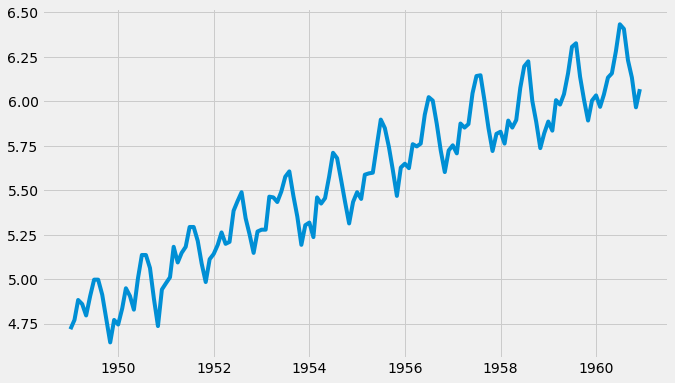

In [92]:
indexedDataset_log = np.log(indexedDataset)
plt.plot(indexedDataset_log)

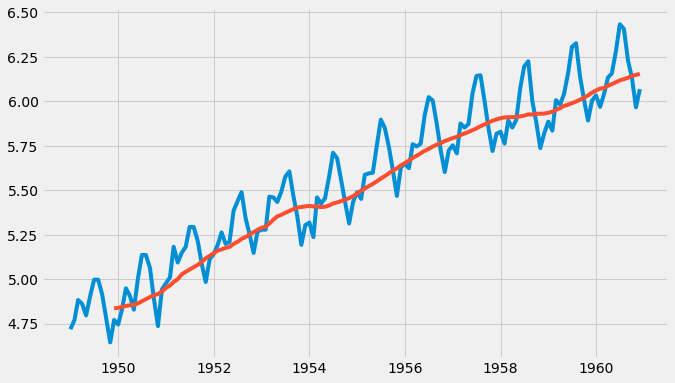

In [94]:
movingAverage = indexedDataset_log.rolling(window=12).mean()

#rolstd = indexedDataset_log.rolling(window=12).std()
plt.plot(indexedDataset_log)
plt.plot(movingAverage)

In [96]:
DMMA = indexedDataset_log - movingAverage
DMMA.dropna(inplace = True)
DMMA.head(10)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


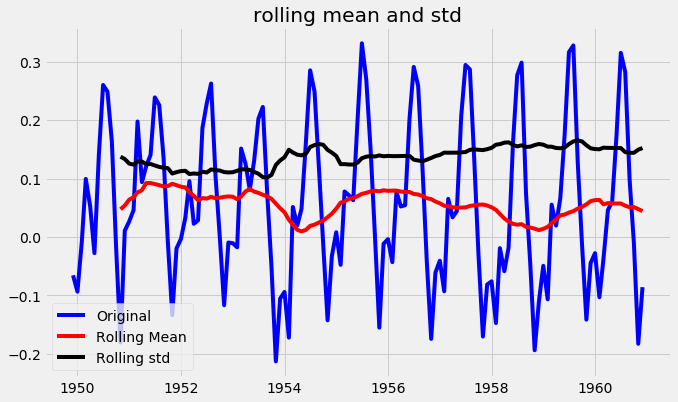

results of dicky-fuller test :
Test Statistics              -3.162908
p-value                       0.022235
#Lags-Used                   13.000000
 No of observations used    119.000000
Criical Value (1%)           -3.486535
Criical Value (5%)           -2.886151
Criical Value (10%)          -2.579896
dtype: float64


In [100]:
def test_stationarity(timeseries):
    #detemining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    #plot
    orig = plt.plot(timeseries, color ='blue', label = 'Original')
    mean = plt.plot(movingAverage, color ='red', label = 'Rolling Mean')
    std = plt.plot(movingSTD, color ='black', label = 'Rolling std')
    plt.legend(loc='best')
    plt.title('rolling mean and std')
    plt.show(block = False)
    
    
    #dicky-fuller test
    
    print("results of dicky-fuller test :")

    dftest = adfuller(timeseries['Passengers'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '#Lags-Used', ' No of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Criical Value (%s)'%key] = value
    
    print(dfoutput) 
    
    
    
test_stationarity(DMMA)  
    
    
#better
    
    
    

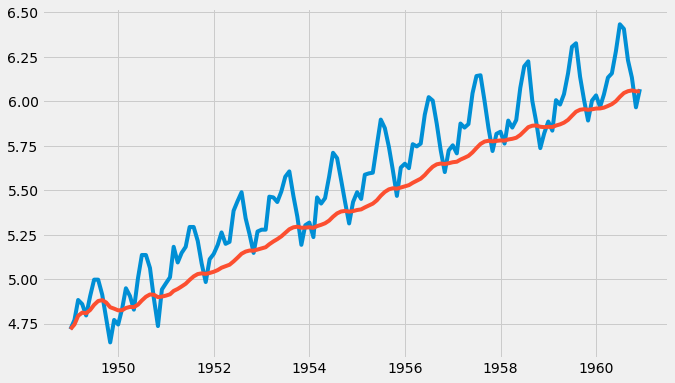

In [101]:
exponentialDecayWeightedAverage = indexedDataset_log.ewm(halflife=12, min_periods = 0, adjust = True).mean()
plt.plot(indexedDataset_log)
plt.plot(exponentialDecayWeightedAverage)


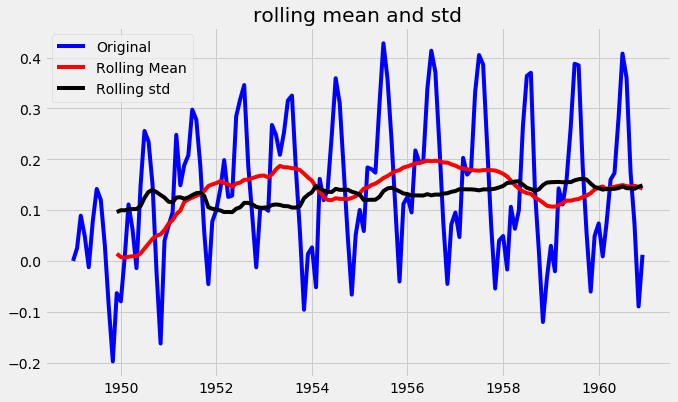

results of dicky-fuller test :
Test Statistics              -3.601262
p-value                       0.005737
#Lags-Used                   13.000000
 No of observations used    130.000000
Criical Value (1%)           -3.481682
Criical Value (5%)           -2.884042
Criical Value (10%)          -2.578770
dtype: float64


In [102]:
DMMEDA = indexedDataset_log - exponentialDecayWeightedAverage
test_stationarity(DMMEDA)

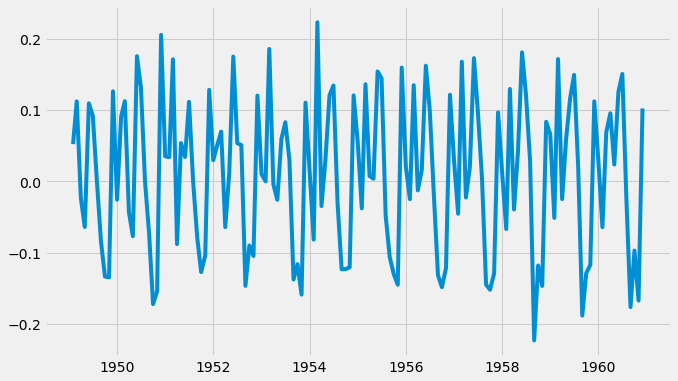

In [103]:
datasetshifting = indexedDataset_log - indexedDataset_log.shift()  # shifting the data ; lag of 1
plt.plot(datasetshifting)

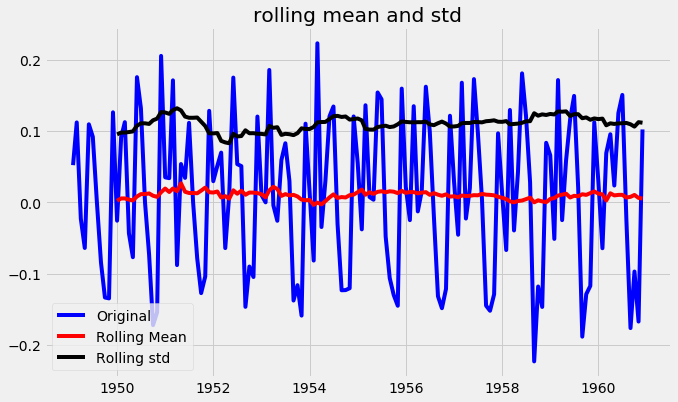

results of dicky-fuller test :
Test Statistics              -2.717131
p-value                       0.071121
#Lags-Used                   14.000000
 No of observations used    128.000000
Criical Value (1%)           -3.482501
Criical Value (5%)           -2.884398
Criical Value (10%)          -2.578960
dtype: float64


In [104]:
datasetshifting.dropna(inplace = True)
test_stationarity(datasetshifting)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition  = seasonal_decompose(indexedDataset_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(indexedDataset_log, label='original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label = 'residual')
plt.legend(loc='best')


decomposedLogdata = residual
decomposedLogdata.dropna(inplace = True)
test_stationarity(decomposedLogdata)    #residue is stationary or not


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

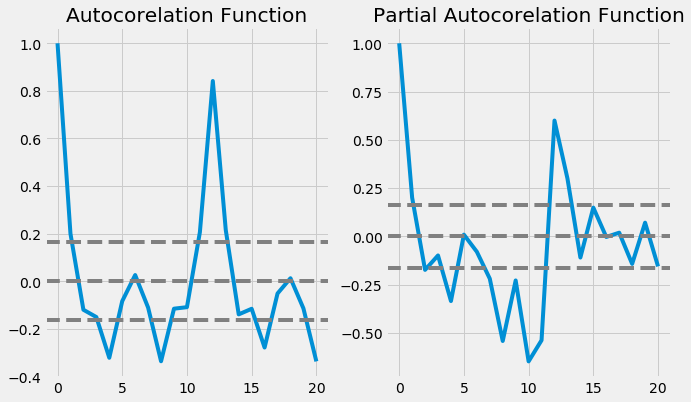

In [118]:
#ACF graph and PACF graph
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(datasetshifting, nlags = 20)
lag_pacf = pacf(datasetshifting, nlags = 20 , method = 'ols') #ordinary least square method

#plot acf

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle='--', color='gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetshifting)), linestyle='--', color='gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetshifting)), linestyle='--', color='gray')
plt.title('Autocorelation Function')


#plot pacf

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle='--', color='gray')
plt.axhline(y = -1.96/np.sqrt(len(datasetshifting)), linestyle='--', color='gray')
plt.axhline(y = 1.96/np.sqrt(len(datasetshifting)), linestyle='--', color='gray')
plt.title('Partial Autocorelation Function')
plt.tight_layout






F:\anaconda\envs\faraz_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
F:\anaconda\envs\faraz_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


plotting AR model


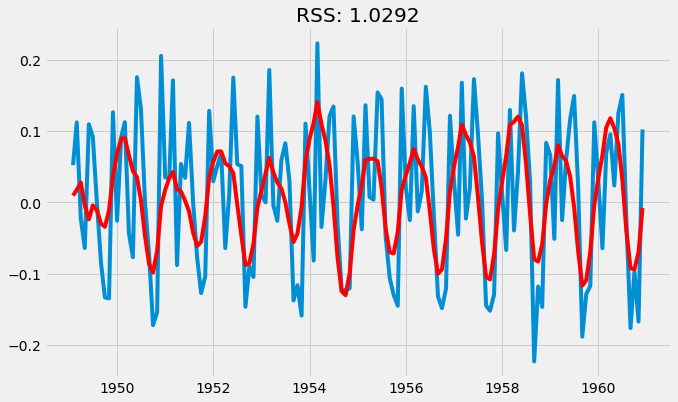

In [129]:
from statsmodels.tsa.arima_model import ARIMA
model =  ARIMA(indexedDataset_log, order=(2,1,2))  #(AR,I,MA)
results_AR = model.fit(disp = -1)
plt.plot(datasetshifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetshifting["Passengers"])**2))
print("plotting AR model")

In [131]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy =True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [148]:
predictions_ARIMA_cumsum = predictions_ARIMA_diff.cumsum()
print(predicitons_ARIMA_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [149]:
predictions_ARIMA_log = pd.Series( indexedDataset_log['Passengers'].ix[0], index = indexedDataset_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_cumsum, fill_value=0)
predictions_ARIMA_log.head()

F:\anaconda\envs\faraz_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

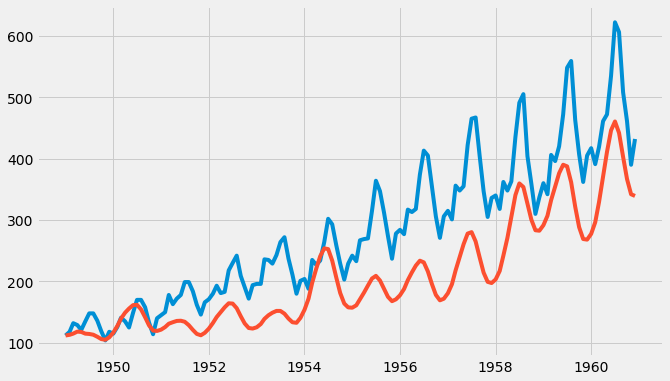

In [152]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [153]:
indexedDataset_log

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


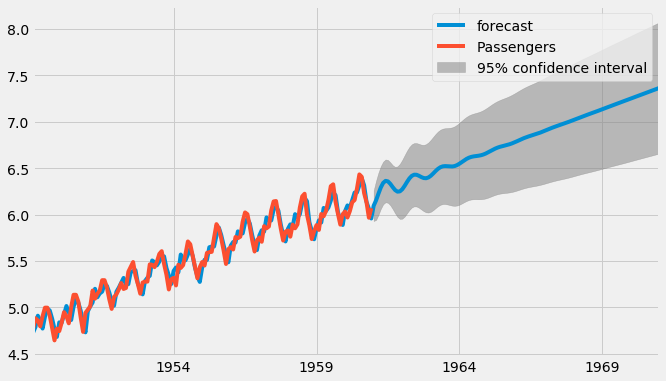

In [156]:
results_AR.plot_predict(1,264)
x = results_AR.forecast(steps = 120)


In [157]:
x

(array([6.09553397, 6.15281411, 6.22442976, 6.29241112, 6.34164725,
        6.36359367, 6.35784689, 6.33139306, 6.29597542, 6.26447717,
        6.24738331, 6.2502518 , 6.27275846, 6.30940322, 6.35151502,
        6.38988663, 6.41727387, 6.43011058, 6.42906693, 6.41842493,
        6.4045616 , 6.39403622, 6.39183091, 6.40019513, 6.41833703,
        6.44295418, 6.46937445, 6.49293994, 6.51024126, 6.5198904 ,
        6.52267585, 6.52112394, 6.51864535, 6.51853699, 6.52311933,
        6.53322372, 6.54812882, 6.56591569, 6.5841032 , 6.6003655 ,
        6.61313276, 6.6219279 , 6.62737797, 6.63093138, 6.63438699,
        6.63937996, 6.64696517, 6.65739854, 6.67015338, 6.68414265,
        6.69806639, 6.71077913, 6.72157744, 6.73033995, 6.73749822,
        6.74386391, 6.75037336, 6.75782606, 6.76668697, 6.77699838,
        6.78841334, 6.80032869, 6.81207209, 6.82308774, 6.8330715 ,
        6.84202506, 6.85022326, 6.85811236, 6.86617355, 6.87479167,
        6.88416319, 6.89426401, 6.90487906, 6.91